# M2Lines Coding Assignment

This is a test to verify your ability to work with a *relatively* simple [codebase](https://github.com/suryadheeshjith/Samudra). We will download code from github and the questions below will give us an understanding of how well you can work with the code. Your understanding will greatly improve if you go through the paper [[1]](https://arxiv.org/pdf/2412.03795). Be sure to use the GPU runtime on google colab, otherwise you will face some issues running the code.

The code here is an ocean "emulator" which predicts future states of the ocean given an initial state. We autoregressively produce new ocean states by providing additional context to the model in the form of "boundary" conditions from the atmosphere.

So our input at each step of the prediction would be Ocean variables and Atmosphere variables concatenated (black) and output would be the predicted ocean state (in orange) for the next time step. Subsequently, we use the output produced as a new input and produce the following ocean state with the corresponding ground truth atmospheric forcing. The schematic below should make things a bit clearer.

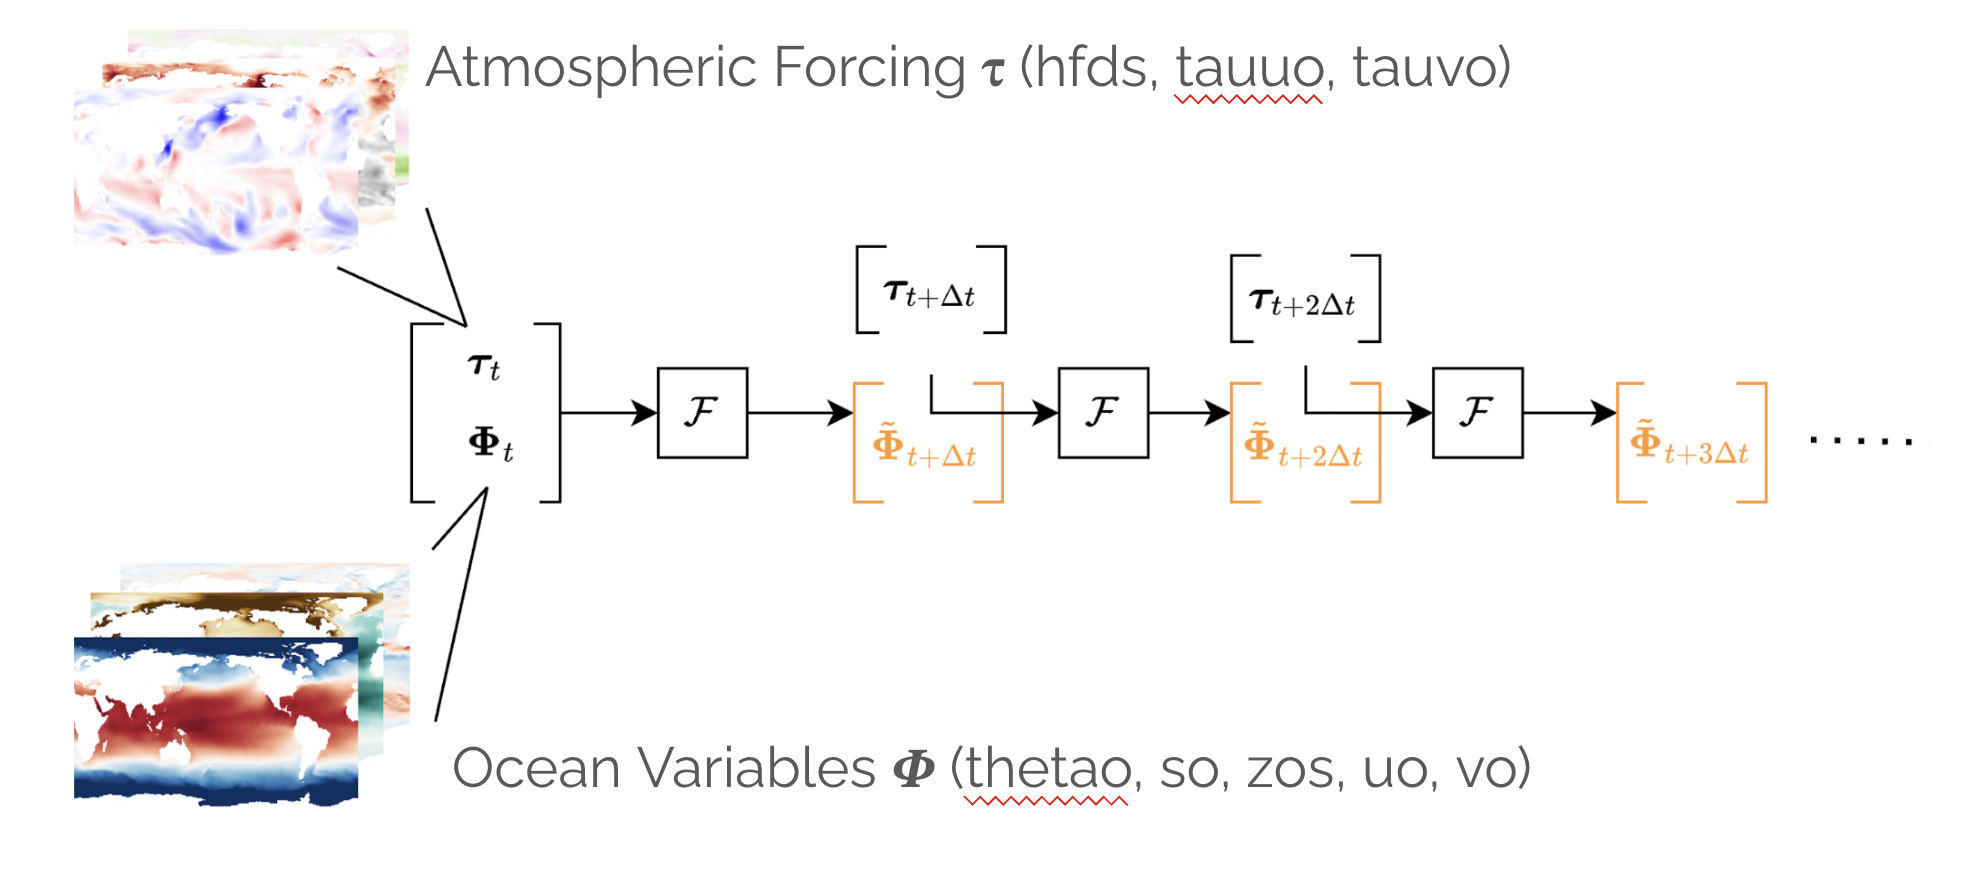

Note: A subtlety to our model is that it uses 2 consecutive input states to produce the next 2 ocean states i.e. t, t+1 -> t+2, t+3. This is not depicted in the diagram above.


Here, the variables in brackets represent physical variables:

__Atmospheric Forcing__

hfds = Heat Flux

tauuo, tauvo = Wind stresses

__Ocean Variables__

thetao = Temperature

so = Salinity

zos = Sea Surface Height

uo, vo = Velocities

The code below should clone a [publicly available repository](https://github.com/suryadheeshjith/Samudra) that has recently been developed by the M2Lines team. Run the below cell for setup:

In [1]:
!git clone https://github.com/suryadheeshjith/Samudra
%cd Samudra
!pip install numcodecs==0.15.1
!pip install zarr==2.16.1
!pip install dacite==1.9.1
!pip install cftime>=1.5.2
!pip install nc-time-axis==1.4.1

Cloning into 'Samudra'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 295 (delta 73), reused 77 (delta 30), pack-reused 162 (from 1)
Receiving objects: 100% (295/295), 38.51 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (144/144), done.
/content/Samudra
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 114.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 18.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5031 sha256=961aef6e0495fa5fa20df440fa8d0fc3da0845c7025d05d6cd85c8344eb20351
  Stored in directory: /root/.cache/pip/wheels/a5/d7/98/f56ae733748cd0fa577172bda0e73e0b1f1793c98e09b9e458
Successfully built asciitree


In [2]:
import matplotlib.pyplot as plt
import xarray as xr

### Q. Data

The data here is a multidimensional ocean dataset that contain both 2D (lat, lon) and 3D (lat, lon, levels) physical variables. The variables that have multiple levels across depth have \_lev\_ appended to their variable name followed by the depth in metres ex. 1050_0 = 1050.0m. For example, thetao has corresponding variables -

```
thetao_lev_1050_0
thetao_lev_105_0   
thetao_lev_10_0  
...
```

But zos, that is recorded only at the surface, does not have values at depth.

Let us read and save the data now.

> Follow the instructions [here](https://github.com/suryadheeshjith/Samudra?tab=readme-ov-file#om4-data) to download the data which includes -
* Precomputed mean and standard deviation statistics
* The Data - Read the data and save ONLY the range between 2014-10-10 to 2015-02-01. Do not attempt to save the entire dataset. It should take you about 2 minutes to download the data.

Use the [xarray](https://docs.xarray.dev/en/stable/index.html) library to load and analyse the data. We also use it during evaluation of model rollouts.

In [3]:
import os
import xarray as xr

MEANS_URL = "https://nyu1.osn.mghpcc.org/m2lines-pubs/Samudra/OM4_means"
STDS_URL = "https://nyu1.osn.mghpcc.org/m2lines-pubs/Samudra/OM4_stds"
DATA_URL = "https://nyu1.osn.mghpcc.org/m2lines-pubs/Samudra/OM4"

save_dir = "./data_dir"

os.makedirs(save_dir, exist_ok=True)


# Mean Statistics
print("Downloading OM4 mean statistics…")
means_ds = xr.open_dataset(MEANS_URL, engine="zarr", chunks={})
means_zarr_path = os.path.join(save_dir, "means.zarr")
means_ds.to_zarr(means_zarr_path, mode="w")
print("Save Successfull mean")

# Std Statistics
print("Downloading OM4 standard deviation statistics…")
stds_ds = xr.open_dataset(STDS_URL, engine="zarr", chunks={})
stds_zarr_path = os.path.join(save_dir, "stds.zarr")
stds_ds.to_zarr(stds_zarr_path, mode="w")
print("Save Successfull std")

#Subset data from range

data_ds = xr.open_dataset(DATA_URL, engine="zarr", chunks={})


start_date = "2014-10-10"
end_date = "2015-02-01"
print(f"Selecting data between {start_date} and {end_date}…")
subset_ds = data_ds.sel(time=slice(start_date, end_date))
subset_zarr_path = os.path.join(save_dir, f"OM4_{start_date}_{end_date}.zarr")
subset_ds.to_zarr(subset_zarr_path, mode="w")
print(f"Saved subset to: {subset_zarr_path}")


#Test
subset_ds.load()
print(subset_ds)


Save Successfull mean
Save Successfull std
Selecting data between 2014-10-10 and 2015-02-01…
Saved subset to: ./data_dir/OM4_2014-10-10_2015-02-01.zarr
<xarray.Dataset> Size: 497MB
Dimensions:            (time: 23, y: 180, x: 360, lev: 19, y_b: 181, x_b: 361)
Coordinates:
    areacello          (y, x) float64 518kB 1.699e+08 1.699e+08 ... 1.699e+08
    dz                 (lev) int64 152B 5 10 15 20 30 ... 600 800 1000 1000 1000
    lat                (y, x) float64 518kB -89.24 -89.24 -89.24 ... 89.24 89.24
    lat_b              (y_b, x_b) float64 523kB -90.0 -90.0 -90.0 ... 90.0 90.0
  * lev                (lev) float64 152B 2.5 10.0 22.5 ... 4e+03 5e+03 6e+03
    lon                (y, x) float64 518kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    lon_b              (y_b, x_b) float64 523kB 0.0 1.0 2.0 ... 359.0 360.0
    ocean_fraction     (lev, y, x) float64 10MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * time               (time) object 184B 2014-10-10 12:00:00 ... 2015-01-28 ...
    wetmask   

Provide below a summary of the statistics of the data variables or anything interesting you learnt with the data. For instance, How does the variance of the 3 dimensional physical variables change over depth?

Ans:

In [62]:
import xarray as xr
import numpy as np

# Load dataset
ds = xr.open_dataset("./data_dir/OM4_2014-10-10_2015-02-01.zarr", engine="zarr")

def build_3d_var(ds, prefix):

    lev_vars = [v for v in ds.data_vars if v.startswith(prefix + "_lev_")]

    parsed = []
    for v in lev_vars:
        if "_lev_" not in v or not v.endswith("_0"):
            continue
        depth_tag = v.split("_lev_", 1)[1].rsplit("_0", 1)[0]
        depth_str = depth_tag.replace("_", ".")
        try:
            depth_val = float(depth_str)
        except ValueError:
            continue
        parsed.append((depth_val, v))

    if not parsed:
        raise ValueError(f"No levels parsed for prefix '{prefix}'. "
                         f"Found candidates: {lev_vars[:8]} ...")

    by_depth = {}
    for d, name in parsed:
        if d not in by_depth:
            by_depth[d] = name
        else:
            cur = ds[by_depth[d]].count().item()
            new = ds[name].count().item()
            if new > cur:
                by_depth[d] = name

    depths_sorted = sorted(by_depth.keys())
    vars_sorted = [by_depth[d] for d in depths_sorted]

    stacked = xr.concat([ds[v] for v in vars_sorted], dim="lev")
    stacked = stacked.assign_coords(lev=("lev", np.array(depths_sorted, dtype=float)))
    stacked.name = prefix
    return stacked, []

thetao_3d, thetao_skipped = build_3d_var(ds, "thetao")
so_3d,     so_skipped     = build_3d_var(ds, "so")
uo_3d,     uo_skipped     = build_3d_var(ds, "uo")
vo_3d,     vo_skipped     = build_3d_var(ds, "vo")


print("thetao_3d dims:", dict(thetao_3d.sizes))
print("thetao levels (m):", thetao_3d.lev.values)

thetao_var_depth = thetao_3d.var(dim="time", skipna=True).mean(dim=("y", "x"), skipna=True)

print("Variance vs depth for thetao:")
print(thetao_var_depth.isel(lev=slice(0, 10)))


thetao_3d dims: {'lev': 17, 'time': 23, 'y': 180, 'x': 360}
thetao levels (m): [  10.   40.   65.  105.  165.  250.  375.  550.  775. 1050. 1400. 1850.
 2400. 3100. 4000. 5000. 6000.]
Variance vs depth for thetao:
<xarray.DataArray 'thetao' (lev: 10)> Size: 40B
array([1.5613798e+00, 8.2209790e-01, 2.9774857e-01, 1.3646927e-01,
       4.3163627e-02, 1.5729243e-02, 8.3991326e-03, 4.9055419e-03,
       2.9450096e-03, 1.4907976e-03], dtype=float32)
Coordinates:
  * lev      (lev) float64 80B 10.0 40.0 65.0 105.0 ... 550.0 775.0 1.05e+03



===== Variance vs depth (global spatial mean) =====

thetao:
  surface (10 m): 1.561
  ~100 m (105 m): 0.1365  (↓ ~11.4× from surface)
  ~1000 m (1050 m): 0.001491 (↓ ~1047.3× from surface)

so:
  surface (10 m): 0.04554
  ~100 m (105 m): 0.001518  (↓ ~30.0× from surface)
  ~1000 m (1050 m): 1.786e-05 (↓ ~2549.3× from surface)

uo:
  surface (10 m): 0.001882
  ~100 m (105 m): 0.0003251  (↓ ~5.8× from surface)
  ~1000 m (1050 m): 5.805e-05 (↓ ~32.4× from surface)

vo:
  surface (10 m): 0.0009639
  ~100 m (105 m): 0.0001892  (↓ ~5.1× from surface)
  ~1000 m (1050 m): 3.862e-05 (↓ ~25.0× from surface)


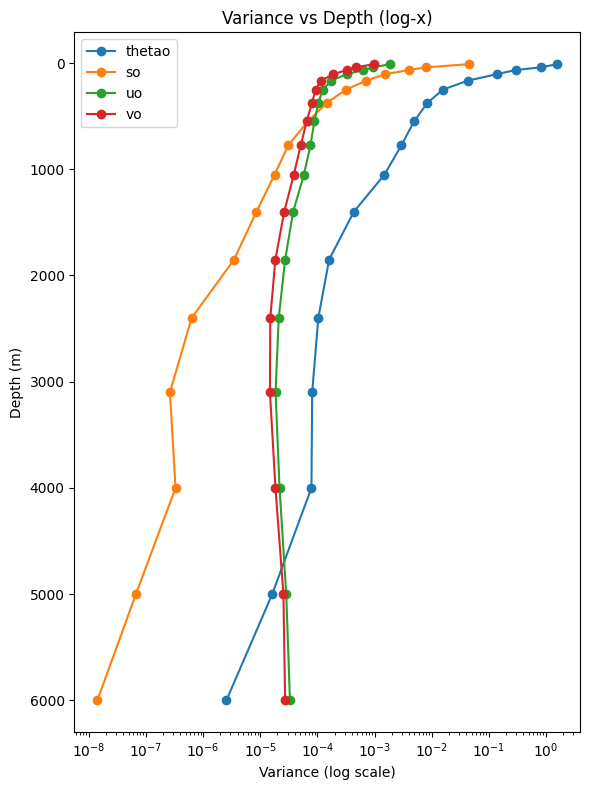

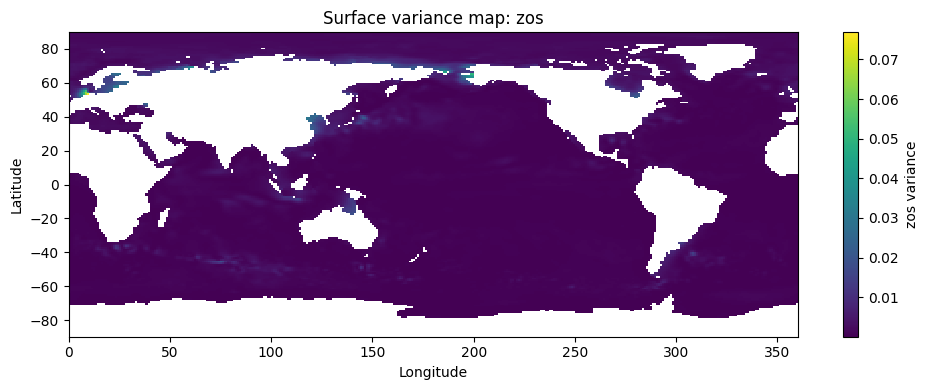

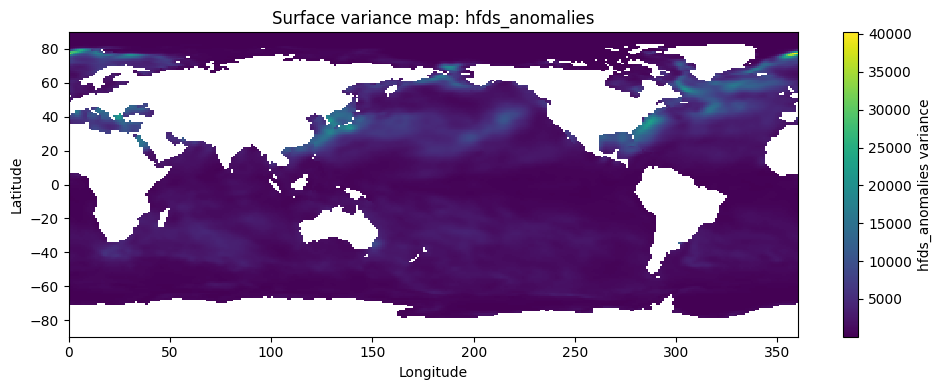

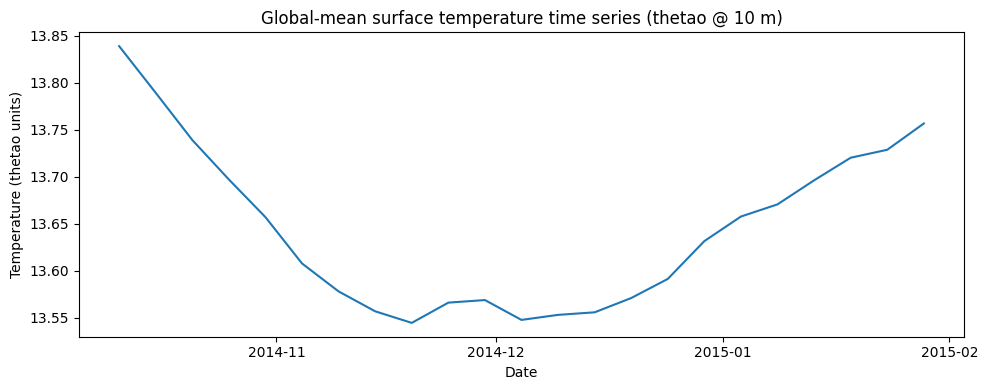

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

def var_profile(da_3d: xr.DataArray) -> xr.DataArray:
    return da_3d.var(dim="time", skipna=True).mean(dim=("y", "x"), skipna=True)

profiles = {}
for name, arr in [("thetao", thetao_3d), ("so", so_3d), ("uo", uo_3d), ("vo", vo_3d)]:
    if isinstance(arr, xr.DataArray):
        profiles[name] = var_profile(arr)


def _nearest_level(levs: np.ndarray, target: float) -> float | None:
    return float(levs[np.argmin(np.abs(levs - target))]) if levs.size else None

print("\n===== Variance vs depth (global spatial mean) =====")
for name, prof in profiles.items():
    levs = prof.lev.values
    sfc = float(levs.min())
    near100 = _nearest_level(levs, 100.0)
    near1000 = _nearest_level(levs, 1000.0)
    v_sfc = float(prof.sel(lev=sfc))
    v_100 = float(prof.sel(lev=near100)) if near100 is not None else np.nan
    v_1000 = float(prof.sel(lev=near1000)) if near1000 is not None else np.nan
    drop_100 = (v_sfc / v_100) if (not np.isnan(v_100) and v_100 > 0) else np.nan
    drop_1000 = (v_sfc / v_1000) if (not np.isnan(v_1000) and v_1000 > 0) else np.nan

    print(f"\n{name}:")
    print(f"  surface ({sfc:g} m): {v_sfc:.4g}")
    if not np.isnan(v_100):
        print(f"  ~100 m ({near100:g} m): {v_100:.4g}  (↓ ~{drop_100:.1f}× from surface)")
    else:
        print("  ~100 m: depth not present")
    if not np.isnan(v_1000):
        print(f"  ~1000 m ({near1000:g} m): {v_1000:.4g} (↓ ~{drop_1000:.1f}× from surface)")
    else:
        print("  ~1000 m: depth not present")


# ---- Plot 1: Variance vs depth (log x-axis to highlight deep values)
if profiles:
    plt.figure(figsize=(6, 8))
    for name, prof in profiles.items():
        vals = np.clip(prof.values, a_min=np.finfo(float).tiny, a_max=None)
        plt.semilogx(vals, prof.lev.values, marker="o", lw=1.5, label=name)
    plt.gca().invert_yaxis()
    plt.xlabel("Variance (log scale)")
    plt.ylabel("Depth (m)")
    plt.title("Variance vs Depth (log-x)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- Plot 2: zos and hfds_anomalies
for sname in ["zos", "hfds_anomalies"]:
    if sname in ds:
        var_map = ds[sname].var(dim="time", skipna=True)  # (y, x)
        plt.figure(figsize=(10, 4))
        lon = ds.get("lon"); lat = ds.get("lat")
        if lon is not None and lat is not None and lon.shape == var_map.shape:
            plt.pcolormesh(lon, lat, var_map, shading="auto")
            plt.xlabel("Longitude"); plt.ylabel("Latitude")
        else:
            plt.imshow(var_map, origin="lower", aspect="auto")
            plt.xlabel("x"); plt.ylabel("y")
        plt.colorbar(label=f"{sname} variance")
        plt.title(f"Surface variance map: {sname}")
        plt.tight_layout()
        plt.show()

# ---- Plot 3: Global-mean surface temperature time series (from shallowest thetao level)
if "thetao" in profiles:
    shallow = float(thetao_3d.lev.min())
    sst_ts = thetao_3d.sel(lev=shallow).mean(dim=("y", "x"), skipna=True)
    plt.figure(figsize=(10, 4))
    sst_ts.plot()
    plt.title(f"Global-mean surface temperature time series (thetao @ {shallow:g} m)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (thetao units)")
    plt.tight_layout()
    plt.show()


### Q. Rollout


Let us now rollout a prediction with some saved model weights. We will use the "thermo" model that predicts - thetao, so, and zos at all levels.

To rollout a model on the data -
1. Download model checkpoint from https://huggingface.co/M2LInES/Samudra/resolve/main/samudra_thermo_seed1.pt
2. Run the rollout command with the samudra rollout config file. You need only change the start and end time for inference (use the entire range of data downloaded above) and the data_dir field. Also change the prognostic_vars_key to "thermo". You should use the --subname <name> flag to save your rollouts to distinct directories.

Use this command as reference:

```bash
python src/rollout.py --config path/to/rollout_config.yaml --ckpt_path path/to/checkpoint.pt  --sub_name newrollout --save_zarr
```


In [21]:
!python src/rollout.py --config rollout_config.patched.yaml --ckpt_path samudra_thermo_seed1.pt --subname rollout_1 --save_zarr


samudra_thermo_seed1.pt
2025-08-25 21:08:58,288 - INFO - Prognostic variables: thetao_0, thetao_1, thetao_2, thetao_3, thetao_4, thetao_5, thetao_6, thetao_7, thetao_8, thetao_9, thetao_10, thetao_11, thetao_12, thetao_13, thetao_14, thetao_15, thetao_16, thetao_17, thetao_18, so_0, so_1, so_2, so_3, so_4, so_5, so_6, so_7, so_8, so_9, so_10, so_11, so_12, so_13, so_14, so_15, so_16, so_17, so_18, zos
2025-08-25 21:08:58,288 - INFO - Boundary variables: tauuo, tauvo, hfds, hfds_anomalies
2025-08-25 21:08:58,288 - INFO - Levels: 19
2025-08-25 21:08:58,290 - INFO - Number of inputs: (hist + 1) * prognostic_vars + boundary_vars = 82
2025-08-25 21:08:58,290 - INFO - Number of outputs: (hist + 1) * prognostic_vars = 78
2025-08-25 21:08:58,290 - INFO - Loading data
2025-08-25 21:08:59,999 - INFO - Instantiating model samudra from checkpoint samudra_thermo_seed1.pt
2025-08-25 21:09:00,000 - INFO - NOTE: Changing input channels to match data 158->82
2025-08-25 21:09:00,000 - INFO - NOTE: Chang

In [26]:
#Rollout_2

!python src/rollout.py --config rollout_config.patched_2.yaml --ckpt_path samudra_thermo_seed2.pt --subname rollout_2 --save_zarr


samudra_thermo_seed2.pt
2025-08-25 21:14:36,241 - INFO - Prognostic variables: thetao_0, thetao_1, thetao_2, thetao_3, thetao_4, thetao_5, thetao_6, thetao_7, thetao_8, thetao_9, thetao_10, thetao_11, thetao_12, thetao_13, thetao_14, thetao_15, thetao_16, thetao_17, thetao_18, so_0, so_1, so_2, so_3, so_4, so_5, so_6, so_7, so_8, so_9, so_10, so_11, so_12, so_13, so_14, so_15, so_16, so_17, so_18, zos
2025-08-25 21:14:36,241 - INFO - Boundary variables: tauuo, tauvo, hfds, hfds_anomalies
2025-08-25 21:14:36,241 - INFO - Levels: 19
2025-08-25 21:14:36,243 - INFO - Number of inputs: (hist + 1) * prognostic_vars + boundary_vars = 82
2025-08-25 21:14:36,244 - INFO - Number of outputs: (hist + 1) * prognostic_vars = 78
2025-08-25 21:14:36,244 - INFO - Loading data
2025-08-25 21:14:38,176 - INFO - Instantiating model samudra from checkpoint samudra_thermo_seed2.pt
2025-08-25 21:14:38,176 - INFO - NOTE: Changing input channels to match data 158->82
2025-08-25 21:14:38,176 - INFO - NOTE: Chang

In [28]:
# Rollout 3

!python src/rollout.py --config rollout_config.patched_3.yaml --ckpt_path samudra_thermo_seed3.pt --subname rollout_3 --save_zarr


samudra_thermo_seed3.pt
2025-08-25 21:15:55,687 - INFO - Prognostic variables: thetao_0, thetao_1, thetao_2, thetao_3, thetao_4, thetao_5, thetao_6, thetao_7, thetao_8, thetao_9, thetao_10, thetao_11, thetao_12, thetao_13, thetao_14, thetao_15, thetao_16, thetao_17, thetao_18, so_0, so_1, so_2, so_3, so_4, so_5, so_6, so_7, so_8, so_9, so_10, so_11, so_12, so_13, so_14, so_15, so_16, so_17, so_18, zos
2025-08-25 21:15:55,688 - INFO - Boundary variables: tauuo, tauvo, hfds, hfds_anomalies
2025-08-25 21:15:55,688 - INFO - Levels: 19
2025-08-25 21:15:55,690 - INFO - Number of inputs: (hist + 1) * prognostic_vars + boundary_vars = 82
2025-08-25 21:15:55,690 - INFO - Number of outputs: (hist + 1) * prognostic_vars = 78
2025-08-25 21:15:55,690 - INFO - Loading data
2025-08-25 21:15:57,442 - INFO - Instantiating model samudra from checkpoint samudra_thermo_seed3.pt
2025-08-25 21:15:57,442 - INFO - NOTE: Changing input channels to match data 158->82
2025-08-25 21:15:57,442 - INFO - NOTE: Chang

In [20]:

CONFIG_IN   = "./configs/rollout_samudra_om4.yaml"
DATA_DIR    = "./data_dir"
SUB_NAME    = "thermo_rollout_full"
CKPT_PATH   = "./samudra_thermo_seed1.pt"


MEANS_PATH  = None
STDS_PATH   = None


import os, sys, urllib.request, subprocess, yaml
from datetime import datetime
import numpy as np

HF_URL = "https://huggingface.co/M2LInES/Samudra/resolve/main/samudra_thermo_seed1.pt"

def abspath_or_default(val, default):
    return os.path.abspath(val) if val else os.path.abspath(default)

def download_ckpt(dst):
    os.makedirs(os.path.dirname(dst) or ".", exist_ok=True)
    if os.path.exists(dst):
        print(f"[info] checkpoint exists: {dst}")
        return
    print(f"[info] downloading -> {dst}")
    urllib.request.urlretrieve(HF_URL, dst)
    print("[info] download complete")

def load_yaml(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

def save_yaml(cfg, path):
    with open(path, "w") as f:
        yaml.safe_dump(cfg, f, sort_keys=False)

def find_time_bounds_from_zarr(zarr_path):
    """
    Tries common time coord names and returns (iso_start, iso_end).
    """
    import xarray as xr
    if not os.path.exists(zarr_path):
        raise FileNotFoundError(f"Zarr path not found: {zarr_path}")
    ds = xr.open_zarr(zarr_path, consolidated=False)
    for name in ["time", "time_centered", "t", "Time"]:
        if name in ds.coords:
            t = ds.coords[name].values
            if t.size == 0:
                continue
            t_min = np.min(t)
            t_max = np.max(t)

            def to_iso(d):

                if hasattr(d, "item"):
                    d = d.item()
                if isinstance(d, (np.datetime64,)):
                    d = np.datetime_as_string(d, unit="s")
                    return d[:10]
                try:
                    return d.isoformat()[:10]
                except Exception:
                    return str(d)[:10]
            return to_iso(t_min), to_iso(t_max)
    raise ValueError("Could not find a recognizable time coordinate in the zarr dataset.")

def patch_cfg(cfg, data_dir, ckpt_path, data_path, means_path, stds_path,
              start_time, end_time):
    # inference dates
    cfg.setdefault("inference", {})
    cfg["inference"]["start_time"] = start_time
    cfg["inference"]["end_time"]   = end_time

    # checkpoint
    cfg["ckpt_path"] = ckpt_path

    # experiment fields
    cfg.setdefault("experiment", {})
    cfg["experiment"]["data_dir"] = data_dir
    cfg["experiment"]["prognostic_vars_key"] = "thermo"

    # data paths
    cfg.setdefault("data", {})
    cfg["data"]["data_path"]       = data_path
    cfg["data"]["data_means_path"] = means_path
    cfg["data"]["data_stds_path"]  = stds_path

    # keep these on
    cfg["save_zarr"] = True
    cfg["disk_mode"] = True
    return cfg

assert os.path.isfile(CONFIG_IN), f"Config not found: {CONFIG_IN}"
rollout_py = "src/rollout.py"
assert os.path.exists(rollout_py), f"Missing {rollout_py} (run from repo root)"


download_ckpt(CKPT_PATH)
CKPT_PATH_ABS = os.path.abspath(CKPT_PATH)


DATA_DIR_ABS = os.path.abspath(DATA_DIR)
DATA_PATH_ABS  = abspath_or_default(DATA_PATH, os.path.join(DATA_DIR_ABS, "OM4_2014-10-10_2015-02-01.zarr"))
MEANS_PATH_ABS = abspath_or_default(MEANS_PATH, os.path.join(DATA_DIR_ABS, "means.zarr"))
STDS_PATH_ABS  = abspath_or_default(STDS_PATH, os.path.join(DATA_DIR_ABS, "stds.zarr"))


try:
    start_iso, end_iso = find_time_bounds_from_zarr(DATA_PATH_ABS)
    print(f"[info] inferred time range from {DATA_PATH_ABS}: {start_iso} -> {end_iso}")
except Exception as e:
    print(f"[warn] auto time infer failed: {e}")
    start_iso = None
    end_iso   = None


cfg = load_yaml(CONFIG_IN)
if start_iso and end_iso:
    cfg = patch_cfg(cfg, DATA_DIR_ABS, CKPT_PATH_ABS,
                    DATA_PATH_ABS, MEANS_PATH_ABS, STDS_PATH_ABS,
                    start_iso, end_iso)
else:
    cfg = patch_cfg(cfg, DATA_DIR_ABS, CKPT_PATH_ABS,
                    DATA_PATH_ABS, MEANS_PATH_ABS, STDS_PATH_ABS,
                    cfg.get("inference", {}).get("start_time", "2014-09-30"),
                    cfg.get("inference", {}).get("end_time",   "2022-12-24"))

CONFIG_OUT = "rollout_config.patched.yaml"
save_yaml(cfg, CONFIG_OUT)

print(f"[info] wrote patched config: {CONFIG_OUT}")
print("  inference.start_time:", cfg["inference"]["start_time"])
print("  inference.end_time:  ", cfg["inference"]["end_time"])
print("  ckpt_path:           ", cfg["ckpt_path"])
print("  experiment.data_dir: ", cfg["experiment"]["data_dir"])
print("  prognostic_vars_key: ", cfg["experiment"]["prognostic_vars_key"])
print("  data.data_path:      ", cfg["data"]["data_path"])
print("  data.means_path:     ", cfg["data"]["data_means_path"])
print("  data.stds_path:      ", cfg["data"]["data_stds_path"])


for pth in [DATA_PATH_ABS, MEANS_PATH_ABS, STDS_PATH_ABS]:
    if not os.path.exists(pth):
        print(f"[warn] missing: {pth}")


cmd = [
    sys.executable, rollout_py,
    "--config", CONFIG_OUT,
    "--ckpt_path", CKPT_PATH_ABS,
    "--sub_name", SUB_NAME,
    "--save_zarr",
]
print("[info] running:", " ".join(cmd))
rc = subprocess.call(cmd)
print("[info] exit code:", rc)


[info] checkpoint exists: ./samudra_thermo_seed1.pt
[info] inferred time range from /content/Samudra/data_dir/OM4_2014-10-10_2015-02-01.zarr: 2014-10-10 -> 2015-01-28
[info] wrote patched config: rollout_config.patched.yaml
  inference.start_time: 2014-10-10
  inference.end_time:   2015-01-28
  ckpt_path:            /content/Samudra/samudra_thermo_seed1.pt
  experiment.data_dir:  /content/Samudra/data_dir
  prognostic_vars_key:  thermo
  data.data_path:       /content/Samudra/data_dir/OM4_2014-10-10_2015-02-01.zarr
  data.means_path:      /content/Samudra/data_dir/means.zarr
  data.stds_path:       /content/Samudra/data_dir/stds.zarr
[info] running: /usr/bin/python3 src/rollout.py --config rollout_config.patched.yaml --ckpt_path /content/Samudra/samudra_thermo_seed1.pt --sub_name thermo_rollout_full --save_zarr
[info] exit code: 2


In [27]:
CONFIG_IN   = "./configs/rollout_samudra_om4.yaml"
DATA_DIR    = "./data_dir"
SUB_NAME    = "thermo_rollout_full_3"
CKPT_PATH   = "./samudra_thermo_seed3.pt"
DATA_PATH   = None
MEANS_PATH  = None
STDS_PATH   = None


import os, sys, urllib.request, subprocess, yaml
from datetime import datetime
import numpy as np

HF_URL = "https://huggingface.co/M2LInES/Samudra/resolve/main/samudra_thermo_seed3.pt"

def abspath_or_default(val, default):
    return os.path.abspath(val) if val else os.path.abspath(default)

def download_ckpt(dst):
    os.makedirs(os.path.dirname(dst) or ".", exist_ok=True)
    if os.path.exists(dst):
        print(f"[info] checkpoint exists: {dst}")
        return
    print(f"[info] downloading -> {dst}")
    urllib.request.urlretrieve(HF_URL, dst)
    print("[info] download complete")

def load_yaml(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

def save_yaml(cfg, path):
    with open(path, "w") as f:
        yaml.safe_dump(cfg, f, sort_keys=False)

def find_time_bounds_from_zarr(zarr_path):
    """
    Tries common time coord names and returns (iso_start, iso_end).
    """
    import xarray as xr
    if not os.path.exists(zarr_path):
        raise FileNotFoundError(f"Zarr path not found: {zarr_path}")
    ds = xr.open_zarr(zarr_path, consolidated=False)
    for name in ["time", "time_centered", "t", "Time"]:
        if name in ds.coords:
            t = ds.coords[name].values
            if t.size == 0:
                continue
            t_min = np.min(t)
            t_max = np.max(t)
            def to_iso(d):
                if hasattr(d, "item"):
                    d = d.item()
                if isinstance(d, (np.datetime64,)):
                    d = np.datetime_as_string(d, unit="s")
                    return d[:10]
                try:
                    return d.isoformat()[:10]
                except Exception:
                    return str(d)[:10]
            return to_iso(t_min), to_iso(t_max)
    raise ValueError("Could not find a recognizable time coordinate in the zarr dataset.")

def patch_cfg(cfg, data_dir, ckpt_path, data_path, means_path, stds_path,
              start_time, end_time):
    # inference dates
    cfg.setdefault("inference", {})
    cfg["inference"]["start_time"] = start_time
    cfg["inference"]["end_time"]   = end_time

    # checkpoint
    cfg["ckpt_path"] = ckpt_path

    # experiment fields
    cfg.setdefault("experiment", {})
    cfg["experiment"]["data_dir"] = data_dir
    cfg["experiment"]["prognostic_vars_key"] = "thermo"

    # data paths
    cfg.setdefault("data", {})
    cfg["data"]["data_path"]       = data_path
    cfg["data"]["data_means_path"] = means_path
    cfg["data"]["data_stds_path"]  = stds_path
    cfg["save_zarr"] = True
    cfg["disk_mode"] = True
    return cfg

assert os.path.isfile(CONFIG_IN), f"Config not found: {CONFIG_IN}"
rollout_py = "src/rollout.py"
assert os.path.exists(rollout_py), f"Missing {rollout_py} (run from repo root)"


download_ckpt(CKPT_PATH)
CKPT_PATH_ABS = os.path.abspath(CKPT_PATH)


DATA_DIR_ABS = os.path.abspath(DATA_DIR)
DATA_PATH_ABS  = abspath_or_default(DATA_PATH, os.path.join(DATA_DIR_ABS, "OM4_2014-10-10_2015-02-01.zarr"))
MEANS_PATH_ABS = abspath_or_default(MEANS_PATH, os.path.join(DATA_DIR_ABS, "means.zarr"))
STDS_PATH_ABS  = abspath_or_default(STDS_PATH, os.path.join(DATA_DIR_ABS, "stds.zarr"))

try:
    start_iso, end_iso = find_time_bounds_from_zarr(DATA_PATH_ABS)
    print(f"[info] inferred time range from {DATA_PATH_ABS}: {start_iso} -> {end_iso}")
except Exception as e:
    print(f"[warn] auto time infer failed: {e}")
    start_iso = None
    end_iso   = None

cfg = load_yaml(CONFIG_IN)
if start_iso and end_iso:
    cfg = patch_cfg(cfg, DATA_DIR_ABS, CKPT_PATH_ABS,
                    DATA_PATH_ABS, MEANS_PATH_ABS, STDS_PATH_ABS,
                    start_iso, end_iso)
else:
    cfg = patch_cfg(cfg, DATA_DIR_ABS, CKPT_PATH_ABS,
                    DATA_PATH_ABS, MEANS_PATH_ABS, STDS_PATH_ABS,
                    cfg.get("inference", {}).get("start_time", "2014-09-30"),
                    cfg.get("inference", {}).get("end_time",   "2022-12-24"))

CONFIG_OUT = "rollout_config.patched_3.yaml"
save_yaml(cfg, CONFIG_OUT)

print(f"[info] wrote patched config: {CONFIG_OUT}")
print("  inference.start_time:", cfg["inference"]["start_time"])
print("  inference.end_time:  ", cfg["inference"]["end_time"])
print("  ckpt_path:           ", cfg["ckpt_path"])
print("  experiment.data_dir: ", cfg["experiment"]["data_dir"])
print("  prognostic_vars_key: ", cfg["experiment"]["prognostic_vars_key"])
print("  data.data_path:      ", cfg["data"]["data_path"])
print("  data.means_path:     ", cfg["data"]["data_means_path"])
print("  data.stds_path:      ", cfg["data"]["data_stds_path"])

for pth in [DATA_PATH_ABS, MEANS_PATH_ABS, STDS_PATH_ABS]:
    if not os.path.exists(pth):
        print(f"[warn] missing: {pth}")

cmd = [
    sys.executable, rollout_py,
    "--config", CONFIG_OUT,
    "--ckpt_path", CKPT_PATH_ABS,
    "--sub_name", SUB_NAME,
    "--save_zarr",
]
print("[info] running:", " ".join(cmd))
rc = subprocess.call(cmd)
print("[info] exit code:", rc)


[info] downloading -> ./samudra_thermo_seed3.pt
[info] download complete
[info] inferred time range from /content/Samudra/data_dir/OM4_2014-10-10_2015-02-01.zarr: 2014-10-10 -> 2015-01-28
[info] wrote patched config: rollout_config.patched_3.yaml
  inference.start_time: 2014-10-10
  inference.end_time:   2015-01-28
  ckpt_path:            /content/Samudra/samudra_thermo_seed3.pt
  experiment.data_dir:  /content/Samudra/data_dir
  prognostic_vars_key:  thermo
  data.data_path:       /content/Samudra/data_dir/OM4_2014-10-10_2015-02-01.zarr
  data.means_path:      /content/Samudra/data_dir/means.zarr
  data.stds_path:       /content/Samudra/data_dir/stds.zarr
[info] running: /usr/bin/python3 src/rollout.py --config rollout_config.patched_3.yaml --ckpt_path /content/Samudra/samudra_thermo_seed3.pt --sub_name thermo_rollout_full_3 --save_zarr
[info] exit code: 2


Save two more rollouts with two other model checkpoints from huggingface.

In [25]:

CONFIG_IN   = "./configs/rollout_samudra_om4.yaml"
DATA_DIR    = "./data_dir"
SUB_NAME    = "thermo_rollout_full_2"
CKPT_PATH   = "./samudra_thermo_seed2.pt"
DATA_PATH   = None
MEANS_PATH  = None
STDS_PATH   = None


import os, sys, urllib.request, subprocess, yaml
from datetime import datetime
import numpy as np

HF_URL = "https://huggingface.co/M2LInES/Samudra/resolve/main/samudra_thermo_seed2.pt"

def abspath_or_default(val, default):
    return os.path.abspath(val) if val else os.path.abspath(default)

def download_ckpt(dst):
    os.makedirs(os.path.dirname(dst) or ".", exist_ok=True)
    if os.path.exists(dst):
        print(f"[info] checkpoint exists: {dst}")
        return
    print(f"[info] downloading -> {dst}")
    urllib.request.urlretrieve(HF_URL, dst)
    print("[info] download complete")

def load_yaml(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

def save_yaml(cfg, path):
    with open(path, "w") as f:
        yaml.safe_dump(cfg, f, sort_keys=False)

def find_time_bounds_from_zarr(zarr_path):
    """
    Tries common time coord names and returns (iso_start, iso_end).
    """
    import xarray as xr
    if not os.path.exists(zarr_path):
        raise FileNotFoundError(f"Zarr path not found: {zarr_path}")
    ds = xr.open_zarr(zarr_path, consolidated=False)
    for name in ["time", "time_centered", "t", "Time"]:
        if name in ds.coords:
            t = ds.coords[name].values
            if t.size == 0:
                continue
            t_min = np.min(t)
            t_max = np.max(t)
            def to_iso(d):
                if hasattr(d, "item"):
                    d = d.item()
                if isinstance(d, (np.datetime64,)):
                    d = np.datetime_as_string(d, unit="s")
                    return d[:10]
                try:
                    return d.isoformat()[:10]
                except Exception:
                    return str(d)[:10]
            return to_iso(t_min), to_iso(t_max)
    raise ValueError("Could not find a recognizable time coordinate in the zarr dataset.")

def patch_cfg(cfg, data_dir, ckpt_path, data_path, means_path, stds_path,
              start_time, end_time):
    # inference dates
    cfg.setdefault("inference", {})
    cfg["inference"]["start_time"] = start_time
    cfg["inference"]["end_time"]   = end_time

    # checkpoint
    cfg["ckpt_path"] = ckpt_path

    # experiment fields
    cfg.setdefault("experiment", {})
    cfg["experiment"]["data_dir"] = data_dir
    cfg["experiment"]["prognostic_vars_key"] = "thermo"

    # data paths
    cfg.setdefault("data", {})
    cfg["data"]["data_path"]       = data_path
    cfg["data"]["data_means_path"] = means_path
    cfg["data"]["data_stds_path"]  = stds_path
    cfg["save_zarr"] = True
    cfg["disk_mode"] = True
    return cfg


assert os.path.isfile(CONFIG_IN), f"Config not found: {CONFIG_IN}"
rollout_py = "src/rollout.py"
assert os.path.exists(rollout_py), f"Missing {rollout_py} (run from repo root)"


download_ckpt(CKPT_PATH)
CKPT_PATH_ABS = os.path.abspath(CKPT_PATH)


DATA_DIR_ABS = os.path.abspath(DATA_DIR)
DATA_PATH_ABS  = abspath_or_default(DATA_PATH, os.path.join(DATA_DIR_ABS, "OM4_2014-10-10_2015-02-01.zarr"))
MEANS_PATH_ABS = abspath_or_default(MEANS_PATH, os.path.join(DATA_DIR_ABS, "means.zarr"))
STDS_PATH_ABS  = abspath_or_default(STDS_PATH, os.path.join(DATA_DIR_ABS, "stds.zarr"))


try:
    start_iso, end_iso = find_time_bounds_from_zarr(DATA_PATH_ABS)
    print(f"[info] inferred time range from {DATA_PATH_ABS}: {start_iso} -> {end_iso}")
except Exception as e:
    print(f"[warn] auto time infer failed: {e}")
    start_iso = None
    end_iso   = None


cfg = load_yaml(CONFIG_IN)
if start_iso and end_iso:
    cfg = patch_cfg(cfg, DATA_DIR_ABS, CKPT_PATH_ABS,
                    DATA_PATH_ABS, MEANS_PATH_ABS, STDS_PATH_ABS,
                    start_iso, end_iso)
else:
    cfg = patch_cfg(cfg, DATA_DIR_ABS, CKPT_PATH_ABS,
                    DATA_PATH_ABS, MEANS_PATH_ABS, STDS_PATH_ABS,
                    cfg.get("inference", {}).get("start_time", "2014-09-30"),
                    cfg.get("inference", {}).get("end_time",   "2022-12-24"))

CONFIG_OUT = "rollout_config.patched_2.yaml"
save_yaml(cfg, CONFIG_OUT)

print(f"[info] wrote patched config: {CONFIG_OUT}")
print("  inference.start_time:", cfg["inference"]["start_time"])
print("  inference.end_time:  ", cfg["inference"]["end_time"])
print("  ckpt_path:           ", cfg["ckpt_path"])
print("  experiment.data_dir: ", cfg["experiment"]["data_dir"])
print("  prognostic_vars_key: ", cfg["experiment"]["prognostic_vars_key"])
print("  data.data_path:      ", cfg["data"]["data_path"])
print("  data.means_path:     ", cfg["data"]["data_means_path"])
print("  data.stds_path:      ", cfg["data"]["data_stds_path"])


for pth in [DATA_PATH_ABS, MEANS_PATH_ABS, STDS_PATH_ABS]:
    if not os.path.exists(pth):
        print(f"[warn] missing: {pth}")


cmd = [
    sys.executable, rollout_py,
    "--config", CONFIG_OUT,
    "--ckpt_path", CKPT_PATH_ABS,
    "--sub_name", SUB_NAME,
    "--save_zarr",
]
print("[info] running:", " ".join(cmd))
rc = subprocess.call(cmd)
print("[info] exit code:", rc)


[info] downloading -> ./samudra_thermo_seed2.pt
[info] download complete
[info] inferred time range from /content/Samudra/data_dir/OM4_2014-10-10_2015-02-01.zarr: 2014-10-10 -> 2015-01-28
[info] wrote patched config: rollout_config.patched_2.yaml
  inference.start_time: 2014-10-10
  inference.end_time:   2015-01-28
  ckpt_path:            /content/Samudra/samudra_thermo_seed2.pt
  experiment.data_dir:  /content/Samudra/data_dir
  prognostic_vars_key:  thermo
  data.data_path:       /content/Samudra/data_dir/OM4_2014-10-10_2015-02-01.zarr
  data.means_path:      /content/Samudra/data_dir/means.zarr
  data.stds_path:       /content/Samudra/data_dir/stds.zarr
[info] running: /usr/bin/python3 src/rollout.py --config rollout_config.patched_2.yaml --ckpt_path /content/Samudra/samudra_thermo_seed2.pt --sub_name thermo_rollout_full_2 --save_zarr
[info] exit code: 2


### Q. Plotting


Here is code that plots a timeseries of temperature for a single level.

In [29]:
import sys
sys.path.append('src/')

In [30]:
# Helper function to standardize the input/output (You may ignore this cell)
from src.utils.notebook import rename_vars, combine_variables_by_level, postprocess_for_plot

def standardize(data: xr.Dataset, data_pred: xr.Dataset):
    """
    Standardizes the data for plotting.
    """
    ds_groundtruth = rename_vars(data)
    pred_dict = {"pred0": {"ds_prediction": data_pred, "ls": ["thetao", "so", "zos"]}}

    if ds_groundtruth.time.size != data_pred.time.size:
        assert ds_groundtruth.time.size == data_pred.time.size + 3
        ds_groundtruth = ds_groundtruth.isel(time=slice(2, -1))

    # Renames so further processing is easier
    ds_groundtruth = ds_groundtruth.rename({"lat": "lat_t", "lon": "lon_t"})
    ds_groundtruth = ds_groundtruth.rename({"y": "lat", "x": "lon"})
    ds_groundtruth, pred_dict = combine_variables_by_level(
        ds_groundtruth, ds_groundtruth.lev, pred_dict
    )

    ### Postprocess predictions for plotting
    ds_groundtruth, pred_dict = postprocess_for_plot(
        ds_groundtruth, ds_groundtruth.areacello, ds_groundtruth.dz, pred_dict
    )
    return ds_groundtruth, pred_dict["pred0"]["ds_prediction"]

In [32]:
data_pred = xr.open_zarr("rollout/rollout_seed1/predictions.zarr")
ds_groundtruth, data_pred = standardize(ds, data_pred) # This standardizes the data so they look similar. Ensure you replace data with the groundtruth data

In [33]:
data_pred

<xarray.Dataset> Size: 216MB
Dimensions:         (time: 20, y: 180, x: 360, lev: 19, y_b: 181, x_b: 361)
Coordinates:
    areacello       (y, x) float64 518kB 1.699e+08 1.699e+08 ... 1.699e+08
  * x               (x) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * y               (y) float64 1kB -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
    dz              (lev) int64 152B 5 10 15 20 30 50 ... 600 800 1000 1000 1000
    lat_t           (y, x) float64 518kB -89.24 -89.24 -89.24 ... 89.24 89.24
    lat_b           (y_b, x_b) float64 523kB ...
  * lev             (lev) float64 152B 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
    lon_t           (y, x) float64 518kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    lon_b           (y_b, x_b) float64 523kB ...
    ocean_fraction  (lev, y, x) float64 10MB ...
  * time            (time) object 160B 2014-10-20 12:00:00 ... 2015-01-23 12:...
    wetmask         (lev, y, x) bool 1MB ...
Dimensions without coordinates: y_b, x_b
Data variables:
    zos             (time, y, x) float32 5MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    thetao          (time, lev, y, x) float32 98MB dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    so              (time, lev, y, x) float32 98MB dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
Attributes:
    model_path:  samudra_thermo_seed1.pt

In [34]:
ds_groundtruth

<xarray.Dataset> Size: 434MB
Dimensions:         (time: 20, y: 180, x: 360, lev: 19, y_b: 181, x_b: 361)
Coordinates:
    areacello       (y, x) float64 518kB 1.699e+08 1.699e+08 ... 1.699e+08
    dz              (lev) int64 152B 5 10 15 20 30 50 ... 600 800 1000 1000 1000
    lat_t           (y, x) float64 518kB -89.24 -89.24 -89.24 ... 89.24 89.24
    lat_b           (y_b, x_b) float64 523kB ...
  * lev             (lev) float64 152B 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
    lon_t           (y, x) float64 518kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    lon_b           (y_b, x_b) float64 523kB ...
    ocean_fraction  (lev, y, x) float64 10MB ...
  * time            (time) object 160B 2014-10-20 12:00:00 ... 2015-01-23 12:...
    wetmask         (lev, y, x) bool 1MB ...
  * x               (x) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * y               (y) float64 1kB -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
Dimensions without coordinates: y_b, x_b
Data variables:
    hfds            (time, y, x) float32 5MB nan nan nan ... -1.47 -1.475 -1.48
    hfds_anomalies  (time, y, x) float32 5MB nan nan nan ... 0.1966 0.2038
    tauuo           (time, y, x) float32 5MB nan nan nan ... 0.01782 0.01775
    tauvo           (time, y, x) float32 5MB nan nan nan ... -0.05099 -0.05069
    zos             (time, y, x) float32 5MB nan nan nan ... -0.6215 -0.6219
    thetao          (time, lev, y, x) float32 98MB nan nan nan ... nan nan nan
    so              (time, lev, y, x) float32 98MB nan nan nan ... nan nan nan
    uo              (time, lev, y, x) float32 98MB nan nan nan ... nan nan nan
    vo              (time, lev, y, x) float32 98MB nan nan nan ... nan nan nan
Attributes:
    m2lines/ocean-emulators_git_hash:  https://github.com/m2lines/ocean_emula...
    regrid_method:                     conservative

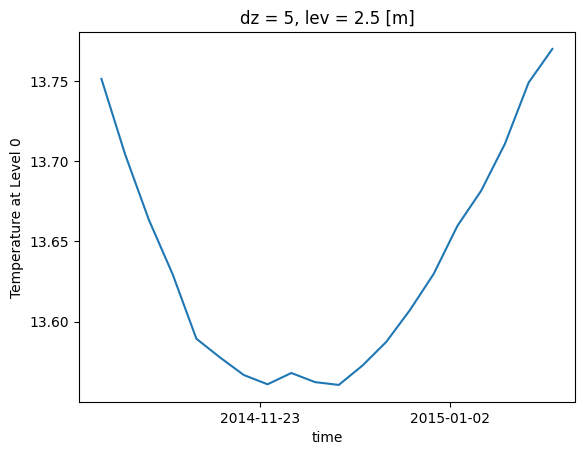

In [35]:
# Here, we can use xarray's plotting capability.
# It is just a thin wrapper around matplotlib.
# We also get elegant x axis time labels
# https://docs.xarray.dev/en/latest/user-guide/plotting.html

data_pred['thetao'].isel(lev=0).mean(['x', 'y']).plot()
l = plt.ylabel('Temperature at Level 0')

#### Task

1. Plot the temperature timeseries averaged over 19 depth levels compared with the groundtruth.

2. Plot the PDF of the predicted and groundtruth temperature.

3. Plot the PDF of the same at range of coordinates: lev=[0,500], x=[118, 260], y=[-5, 5]. Can you guess what part of the ocean this refers to?

4. Plot the spatial correlation coefficient for Temperature and Salinity at the 0th level. Then, compute the Anomaly Correlation Coefficient (ACC) for the same. Plot both as a timeseries.

##### Correlation Coefficient

The general correlation coefficient gives how well the predicted spatial field correlated with the ground truth at time t.

$$CC(u,\tilde{u}, t) = \frac{\sum_{i,j}^{N_x,N_y}u_{i,j,t}\tilde{u}_{i,j,t}}{\sqrt{\sum_{i,j}^{N_x,N_y}\left( u_{i,j,t} \right)^2\sum_{i,j}^{N_x,N_y}\left( \tilde{u}_{i,j,t} \right)^2}}$$

##### Anomaly Correlation Coefficient

The anomaly correlation coefficient gives how well the predicted spatial field correlated with the anomalies outside of seasonality. To compute this we remove the seasonal pointwise mean from the ground truth and the prediction and then compute the correlation as is standard.

$$ACC(u,\tilde{u}, t) = \frac{\sum_{i,j}^{N_x,N_y}(u_{i,j,t}-C_{i,j,t})(\tilde{u}_{i,j,t}-C_{i,j,t})}{\sqrt{\sum_{i,j}^{N_x,N_y}\left( u_{i,j,t}-C_{i,j,t} \right)^2\sum_{i,j}^{N_x,N_y}\left( \tilde{u}_{i,j,t}-C_{i,j,t} \right)^2}}$$

We have provided the function to compute the climatology. Is there something interesting with the ACC calculated? What are we missing in the data to get a meaningful result?

5. Plot the variance across the three rollouts for temperature at a given level. Create three separate plots for level 0, 5, and 10 and ensure they are compared with the groundtruth.

You are encouraged to find other ways to plot the predictions.


For v) your plot could look something like this. Be sure to plot the groundtruth (a timeseries with no spread) as well.

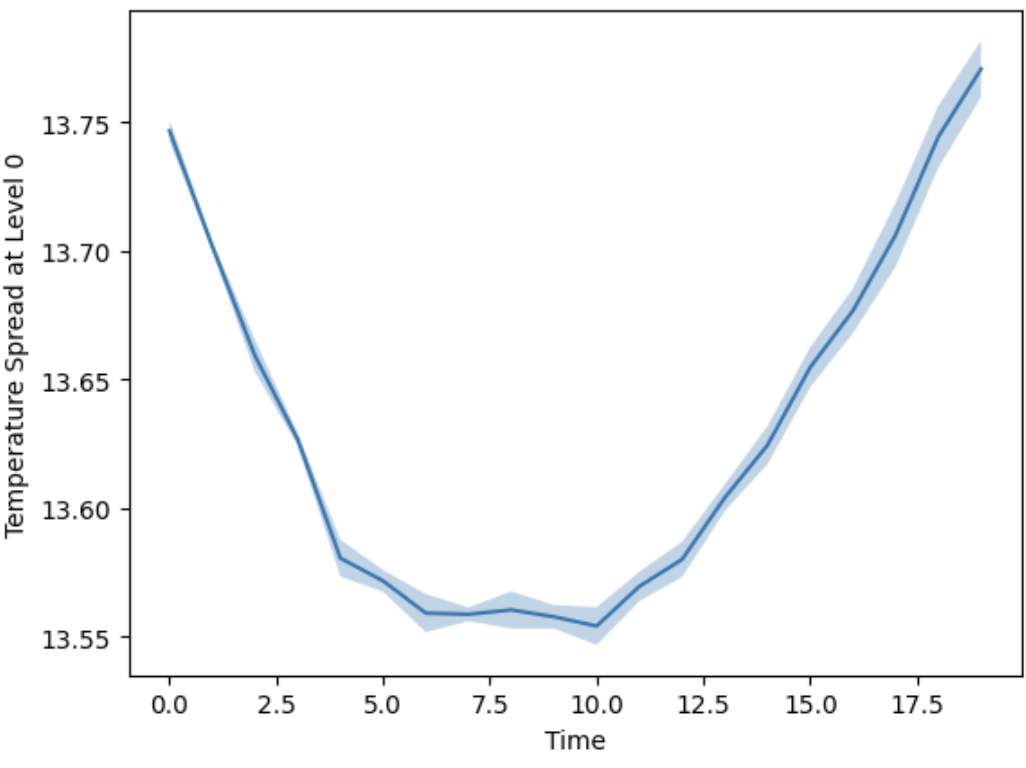

In [36]:
def compute_clim(data: xr.Dataset, var: str, level_index: int):
    # Computes climatology by finding the mean state for each day of the year i.e. Seasonality
    clim = data.isel(lev=level_index)[var].copy()
    clim = clim.groupby('time.dayofyear').mean('time')
    times = [data_pred.time[data_pred.time.dt.dayofyear.values == doy].item() for doy in clim.dayofyear.values]
    clim = clim.rename({"dayofyear": "time"})
    clim = clim.assign_coords(time=("time", times))
    return clim

In [44]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


TEMP_VAR = "thetao"
SALT_VAR = "so"


rollout_paths = [
    "rollout/rollout_seed1/predictions.zarr",
    "rollout/rollout_seed2/predictions.zarr",
    "rollout/rollout_seed3/predictions.zarr",
]


def spatial_dims(da):
    dims = list(da.dims)
    if "lat" in dims and "lon" in dims:
        return ("lat", "lon")
    if "y" in dims and "x" in dims:
        return ("y", "x")
    return tuple(dims[-2:])

preds = []
for p in rollout_paths:
    pr_raw = xr.open_zarr(p, consolidated=False)
    ds_gt_std, pr_std = standardize(ds, pr_raw)  # your function
    preds.append(pr_std)

gt = ds_gt_std
print("GT dims:", {k: v for k, v in gt.dims.items()})
print("Pred dims:", {k: v for k, v in preds[0].dims.items()})


GT dims: {'time': 20, 'y': 180, 'x': 360, 'lev': 19, 'y_b': 181, 'x_b': 361}
Pred dims: {'time': 20, 'y': 180, 'x': 360, 'lev': 19, 'y_b': 181, 'x_b': 361}


/tmp/ipython-input-3698351913.py:35: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("GT dims:", {k: v for k, v in gt.dims.items()})
<frozen _collections_abc>:894: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-3698351913.py:36: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Pred dims:", {k: v for k, v in preds[0].dims.items()})


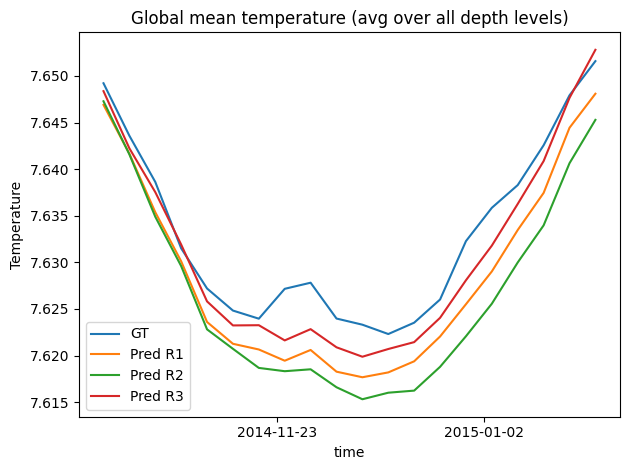

In [45]:
latdim, londim = spatial_dims(gt[TEMP_VAR])

gt_ts = gt[TEMP_VAR].mean(dim=("lev", latdim, londim))
plt.figure()
gt_ts.plot(label="GT")
for i, pr in enumerate(preds, 1):
    pr_ts = pr[TEMP_VAR].mean(dim=("lev", latdim, londim))
    pr_ts.plot(label=f"Pred R{i}")
plt.title("Global mean temperature (avg over all depth levels)")
plt.ylabel("Temperature")
plt.legend()
plt.tight_layout()
plt.show()


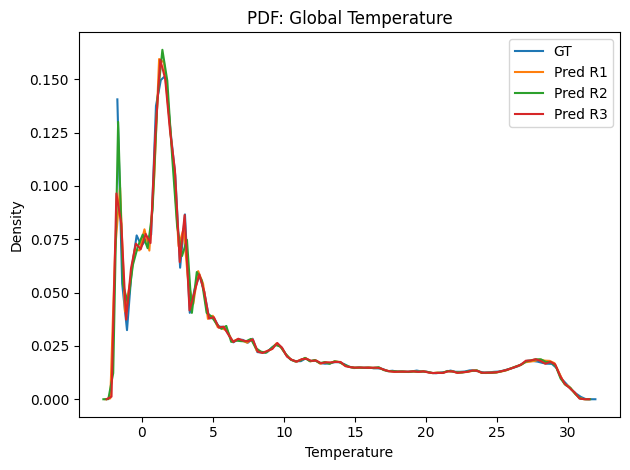

In [46]:
def pdf_of_field(da, bins=100):
    vals = da.values.ravel()
    vals = vals[np.isfinite(vals)]
    hist, edges = np.histogram(vals, bins=bins, density=True)
    centers = 0.5 * (edges[1:] + edges[:-1])
    return centers, hist

plt.figure()
c_gt, d_gt = pdf_of_field(gt[TEMP_VAR])
plt.plot(c_gt, d_gt, label="GT")
for i, pr in enumerate(preds, 1):
    c, d = pdf_of_field(pr[TEMP_VAR])
    plt.plot(c, d, label=f"Pred R{i}")
plt.xlabel("Temperature")
plt.ylabel("Density")
plt.title("PDF: Global Temperature")
plt.legend()
plt.tight_layout()
plt.show()


Provide below some insight or anything interesting you learnt:

Ans:

In [57]:
def spatial_correlation_cc(gt2d: xr.DataArray, pr2d: xr.DataArray) -> float:
    g = gt2d.values.ravel()
    p = pr2d.values.ravel()
    m = np.isfinite(g) & np.isfinite(p)
    if m.sum() < 3:
        return np.nan
    g = g[m] - g[m].mean()
    p = p[m] - p[m].mean()
    num = np.sum(g * p)
    den = np.sqrt(np.sum(g**2) * np.sum(p**2))
    return float(num / den) if den > 0 else np.nan

def cc_timeseries(gt: xr.Dataset, pr: xr.Dataset, var: str, lev_idx: int) -> xr.DataArray:
    gt_level = gt.isel(lev=lev_idx)[var]
    pr_level = pr.isel(lev=lev_idx)[var]
    gt_a, pr_a = xr.align(gt_level, pr_level, join="inner")
    vals = []
    for t in gt_a.time.values:
        vals.append(spatial_correlation_cc(gt_a.sel(time=t), pr_a.sel(time=t)))
    return xr.DataArray(vals, coords={"time": gt_a.time}, dims=("time",))

def acc_timeseries(gt: xr.Dataset, pr: xr.Dataset, var: str, lev_idx: int) -> xr.DataArray:
    clim = compute_clim(gt, var, level_index=lev_idx)  # uses your function
    gt_level = gt.isel(lev=lev_idx)[var]
    pr_level = pr.isel(lev=lev_idx)[var]
    gt_a, pr_a, clim_a = xr.align(gt_level, pr_level, clim, join="inner")
    ga = gt_a - clim_a
    pa = pr_a - clim_a
    vals = []
    for t in gt_a.time.values:
        vals.append(spatial_correlation_cc(ga.sel(time=t), pa.sel(time=t)))
    return xr.DataArray(vals, coords={"time": gt_a.time}, dims=("time",))


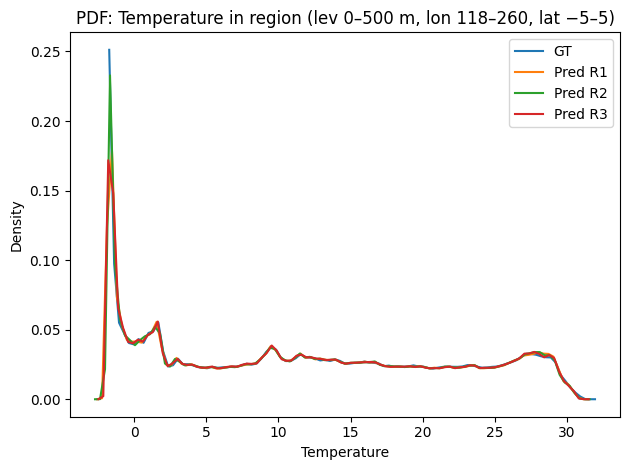

In [47]:

REG_LEV_MIN = 0
REG_LEV_MAX = 500
REG_LON_MIN = 118.0
REG_LON_MAX = 260.0
REG_LAT_MIN = -5.0
REG_LAT_MAX = 5.0

def region_pdf(ds_in, var):
    da = ds_in[var]
    latdim, londim = spatial_dims(da)

    if "lev" in da.coords and np.issubdtype(da["lev"].dtype, np.number):
        da = da.sel(lev=slice(REG_LEV_MIN, REG_LEV_MAX))
    else:
        da = da.isel(lev=slice(0, 5))

    if "lat" in da.coords:
        da = da.sel(lat=slice(REG_LAT_MIN, REG_LAT_MAX))
    if "lon" in da.coords:
        da = da.sel(lon=slice(REG_LON_MIN, REG_LON_MAX))

    return pdf_of_field(da)

plt.figure()
c_gt, d_gt = region_pdf(gt, TEMP_VAR)
plt.plot(c_gt, d_gt, label="GT")
for i, pr in enumerate(preds, 1):
    c, d = region_pdf(pr, TEMP_VAR)
    plt.plot(c, d, label=f"Pred R{i}")
plt.xlabel("Temperature")
plt.ylabel("Density")
plt.title("PDF: Temperature in region (lev 0–500 m, lon 118–260, lat −5–5)")
plt.legend()
plt.tight_layout()
plt.show()


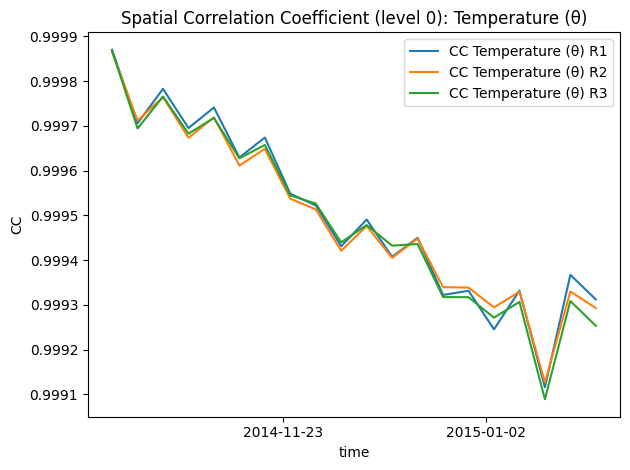

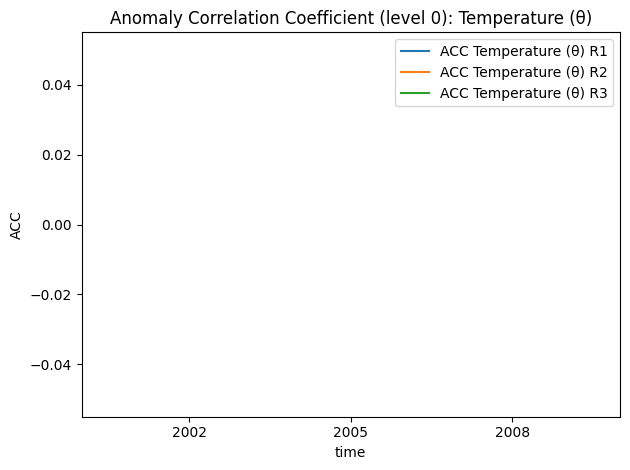

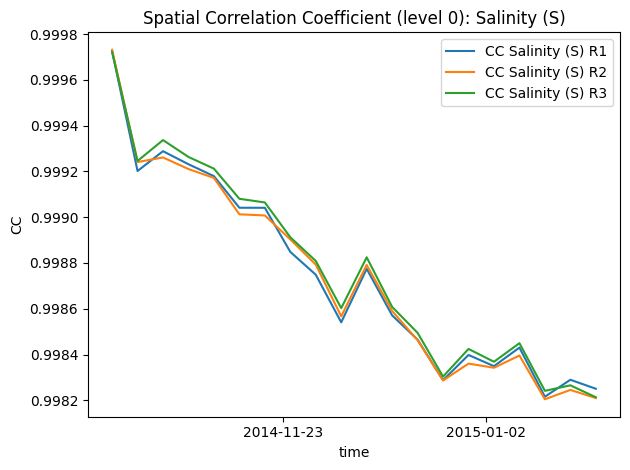

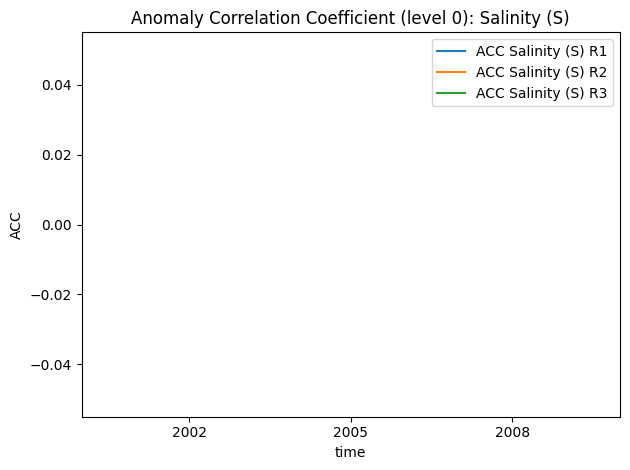

In [49]:
for var, pretty in [(TEMP_VAR, "Temperature (θ)"), (SALT_VAR, "Salinity (S)")]:
    # CC
    plt.figure()
    for i, pr in enumerate(preds, 1):
        cc_ts = cc_timeseries(gt, pr, var, lev_idx=0)
        cc_ts.plot(label=f"CC {pretty} R{i}")
    plt.title(f"Spatial Correlation Coefficient (level 0): {pretty}")
    plt.ylabel("CC")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ACC
    plt.figure()
    for i, pr in enumerate(preds, 1):
        acc_ts = acc_timeseries(gt, pr, var, lev_idx=0)
        acc_ts.plot(label=f"ACC {pretty} R{i}")
    plt.title(f"Anomaly Correlation Coefficient (level 0): {pretty}")
    plt.ylabel("ACC")
    plt.legend()
    plt.tight_layout()
    plt.show()


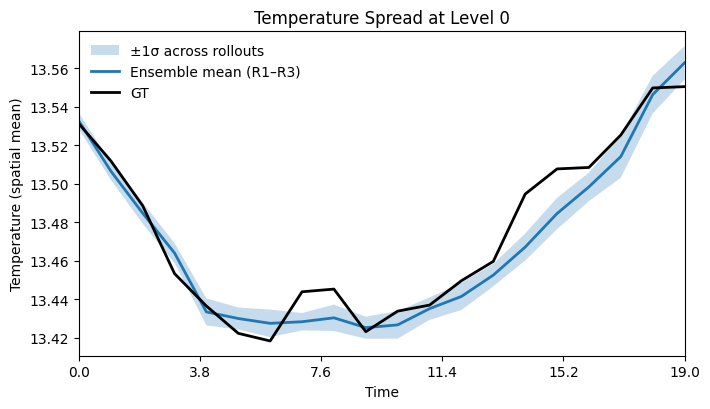

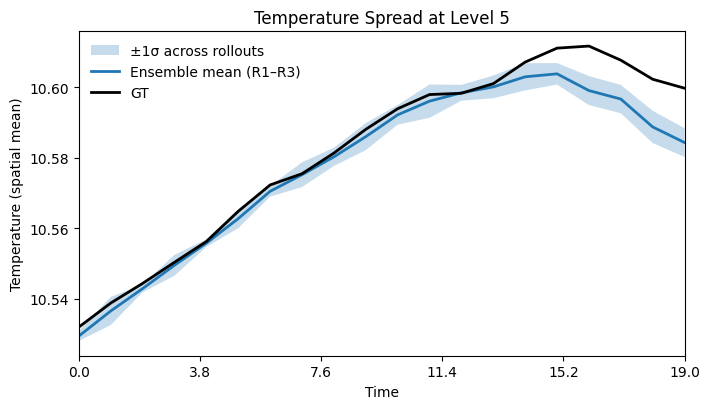

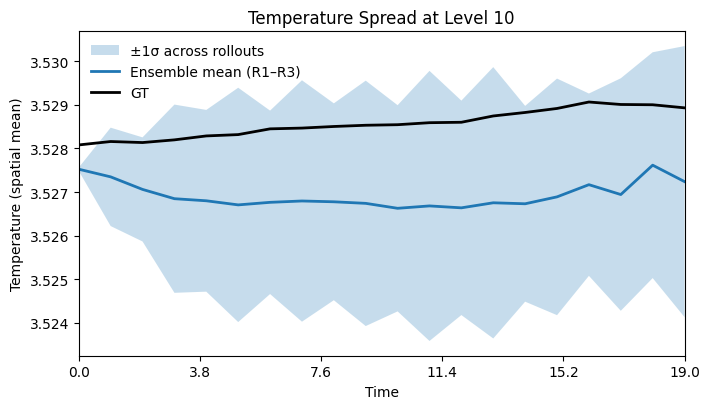

In [63]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


levels = [0, 5, 10]

for lev in levels:
    w_area = area_weights(gt, gt[TEMP_VAR].isel(lev=lev).isel(time=0))

    gt_ts = spatial_mean_timeseries(gt, TEMP_VAR, lev, w=w_area)

    r_ts = [spatial_mean_timeseries(pr, TEMP_VAR, lev, w=w_area) for pr in preds]
    R = xr.concat(r_ts, dim="rollout")

    mean_ts = R.mean(dim="rollout")
    std_ts  = R.std(dim="rollout")
    T = mean_ts.sizes["time"]
    t_idx = np.arange(T)

    fig, ax = plt.subplots(figsize=(7.2, 4.2))

    # shaded ±1σ band
    ax.fill_between(
        t_idx,
        (mean_ts - std_ts).values,
        (mean_ts + std_ts).values,
        alpha=0.25, linewidth=0, label="±1σ across rollouts"
    )

    # ensemble mean
    ax.plot(t_idx, mean_ts.values, lw=2.0, label="Ensemble mean (R1–R3)")

    # GT line
    ax.plot(t_idx, gt_ts.values, lw=2.0, color="k", label="GT")

    ax.set_title(f"Temperature Spread at Level {lev}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (spatial mean)")
    ax.set_xlim(0, T - 1)
    ax.set_xticks(np.linspace(0, T - 1, num=6))

    ax.legend(loc="upper left", frameon=False)
    plt.tight_layout()
    plt.show()


Bonus: There are some differences between the values we get in the predicted temperatures in this notebook and what is present in the paper. We skipped an important factor while computing the mean over space/depth. What do you think it is? Try reproducing a plot from the paper to verify your answer! HINT: You need to use other data that is present in ds_groundtruth

Ans:

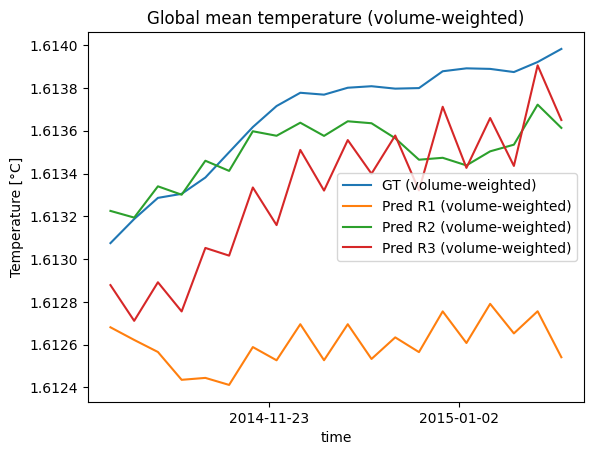

In [52]:
latdim, londim = spatial_dims(gt[TEMP_VAR])
vol_weights = (gt["areacello"] * gt["dz"]).transpose("lev", latdim, londim)

def volume_weighted_mean(ds, var):
    return (ds[var] * vol_weights).sum(dim=("lev", latdim, londim)) / vol_weights.sum(dim=("lev", latdim, londim))

# GT
gt_ts_vol = volume_weighted_mean(gt, TEMP_VAR)

# Predictions
pred_ts_vols = [volume_weighted_mean(pr, TEMP_VAR) for pr in preds]

plt.figure()
gt_ts_vol.plot(label="GT (volume-weighted)")
for i, ts in enumerate(pred_ts_vols, 1):
    ts.plot(label=f"Pred R{i} (volume-weighted)")
plt.title("Global mean temperature (volume-weighted)")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.show()


### Q. Model

1. Describe the Multi-headed self attention (MHSA) module [2] in terms of how the input is successively transformed into an output. Specify the shapes as well at each step. Assume the shape of the input is B x N x C where B, N, C are batch size, sequence length and embedding dimension. Write code in numpy for MHSA.

2. In the Swin Transformer paper [3], they specify complexity as
$$
\Omega(\text{MSA}) = 4hwC^2 + 2(hw)^2C,\\
\Omega(\text{W-MSA}) = 4hwC^2 + 2M^2hwC,
$$
Can you explain how they achieved this result?

### References
1. Dheeshjith, S., Subel, A., Adcroft, A., Busecke, J., Fernandez-Granda, C., Gupta, S., & Zanna, L. (2024). Samudra: An ai global ocean emulator for climate. arXiv preprint arXiv:2412.03795.
2. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.
3. Liu, Z., Lin, Y., Cao, Y., Hu, H., Wei, Y., Zhang, Z., ... & Guo, B. (2021). Swin transformer: Hierarchical vision transformer using shifted windows. In Proceedings of the IEEE/CVF international conference on computer vision (pp. 10012-10022).

If you find anything that can be improved in the current codebase, I encourage you to make an issue/PR [here](https://github.com/suryadheeshjith/Samudra). Thanks!